In [ ]:
from google.colab import files
up = files.upload()
import io
df  = pd.read_csv(io.BytesIO(up['Precipitazioni - 2023 - Foglio2.csv']))

In [ ]:
df = df.iloc[:11448,:]  #eliminate empty rows at the end

In [ ]:
df.head(5)

In [ ]:
df.tail(5)

In [ ]:
for i in range(len(string_list)):                       #check duplicates of column names
    for j in range(i+1, len(string_list)):
        if string_list[i] in string_list[j]:
            print(f'{string_list[i]} is contained in {string_list[j]}')
        elif string_list[j] in string_list[i]:
            print(f'{string_list[j]} is contained in {string_list[i]}')

In [ ]:
for i, col1 in enumerate(df.columns):                 # check presence of identical columns
    for col2 in df.columns[i+1:]:

        if (df[col1] == df[col2]).all():
            print(f"{col1} and {col2} are equal in DataFrame")
        else:
          continue

In [ ]:
for col in df.columns[1:]:                           # check if column contains value that are not float
    if not isinstance(df[col], pd.Series):
        continue
    if not (df[col].apply(lambda x: isinstance(x, float) or np.isnan(x))).all():
        print(f"Column '{col}' contains non-float values.")

### HANDLING MISSING VALUES


"Arpa Lombardia", the owner of the data,  marks missing values with the value -999. Therefore, there is the necessity to check if there are a very long sequence of -999. Moreover, following the theory, I decide to replace them with the mean of the n days before the missing days, with n being the number of missing values. However, this is the case only for sequences smaller than elevel continuos -999.

In [ ]:
def find_consecutive_minus_999(df):
    result_dict = {}
    for col in df.columns[1:]:
        minus_999_mask = (df[col] == -999)
        sequences = minus_999_mask.ne(minus_999_mask.shift()).cumsum()[minus_999_mask]
        seq_lengths = sequences.groupby(sequences).size().tolist()
        result_dict[col] = seq_lengths
    return result_dict

In [ ]:
x = find_consecutive_minus_999(df)

In [ ]:
y = {key: value for key, value in x.items()}
y

In [ ]:
y = {key: value for key, value in x.items() if value > 60}  #check that sequence of -999 are longer than 60
y

In [ ]:
def modify_dataframe(df):
  for column in df.columns[:]:
    num_consecutive_neg_999 = 0
    i = 0
    while i < len(df)-1:
      if df.at[i,column] == -999:
        num_consecutive_neg_999 += 1
        i += 1
        continue
      else:
        if num_consecutive_neg_999 == 0:
          i+=1
          continue
        elif num_consecutive_neg_999 < 10:
          try:
            a=[df.at[i-num_consecutive_neg_999-1,column],df.at[i,column]]
            df.loc[i-num_consecutive_neg_999:i-1, column] = np.nanmean(a)
            num_consecutive_neg_999 = 0
            i += 1
            continue
          except:
            a=[df.at[i,column]]
            df.loc[i-num_consecutive_neg_999:i-1, column] = np.nanmean(a)
            num_consecutive_neg_999 = 0
            i += 1
            continue
        else:
            num_consecutive_neg_999 = 0
            i+=1
            continue
    continue
 return df

In [ ]:
modify_dataframe(df)

In [ ]:
df = df.replace(-999, np.nan)  #replace the longer sequences with np.nan

### CREATION OF DAILY RAINFALL DATASET
The first step in the statisitcal anlysis is understanding whether each station is characterized by stationarity by using autocorrelation functions in R. For this purpose there is the need of a sequence without missing values for each station. However, there is not a period where all the 278 stations have no missing values. Therefore, I take the longest sequence without NaN for each station.

In [ ]:
# Create an empty dataframe to store the longest sequence without NaN for each station
def longest_sequence(df):
  new_df = pd.DataFrame(columns=df.columns)

  # Loop through each column (except the first one)
  for col in df.columns[1:]:
      values = df[col]
      start_idx, end_idx = 0, 0
      max_length, curr_length = 0, 0

      # Loop through each value in the column
      for i, val in values.iteritems():
          if pd.isna(val):
              # End of sequence
              if curr_length > max_length:
                  max_length = curr_length
                  end_idx = i-1
                  start_idx = end_idx - max_length + 1
              curr_length = 0
          else:
              curr_length += 1

      # If the last sequence is the longest one
      if curr_length > max_length:
          max_length = curr_length
          end_idx = i
          start_idx = end_idx - max_length + 1

      # Add the selected range of values to the new dataframe
      new_df[col] = df[col].iloc[start_idx:end_idx+1].reset_index(drop=True)
  return(new_df)


In [ ]:
new_df = longest_sequence(df)

In [ ]:
new_df = new_df/10   #data was imported with a problem and all the observations were multiplied by 10 so I divide by 10 to go back to the usual value

In [ ]:
from google.colab import files
new_df.to_csv('daily_278.csv', index=None, header=True)
files.download('daily_278.csv')

## BIWEEKLY AVERAGE RAINFALL
Since the daily rainfall data show seasonality, the next step is trying aggregating the data in a biweekly average to decrease the correlation between close lags.  

In [ ]:
def create_biweekly_df(df):
  biweekly_df = pd.DataFrame(np.full(((len(df)//15)+1,len(df.columns[1:])), np.nan), columns=df.columns[1:])
  for col in df.columns[1:]:
      for i in range(0,int(len(df)//15)):
        if df.iloc[i*15:(i*15)+15, df.columns.get_loc(col)].isnull().values.any():
            biweekly.loc[i, col] = np.nan
        else:
            biweekly_df.loc[i, col] = np.mean(df.iloc[i*15:(i*15)+15, df.columns.get_loc(col)])
  biweekly_df.index = df.iloc[::15, 0].reset_index(drop=True)
  return(biweekly_df)

In [ ]:
biweekly_df = create_biweekly_df(df)

In [ ]:
biweekly_df = biweekly_df/10

In [ ]:
new_df_b = longest_sequence(biweekly_df)

In [ ]:
from google.colab import files
new_df_b.to_csv('biweekly_278.csv', index=None, header=True)
files.download('biweekly_278.csv')

## MONTHLY AVERAGE RAINFALL

Even the biweekly average shows seasonality, the next step is trying aggregating the data in a monthly average to decrease the correlation between close lags.  Moreover, biweekly average is characterized in many stations by many values equal to 0.

In [ ]:
def create_monthly_df(df):
  monthly_df = pd.DataFrame(np.full(((len(df)//30)+1,len(df.columns[1:])), np.nan), columns=df.columns[1:])  #assume a month is made of 30 days
  for col in df.columns[1:]:
      for i in range(0,int(len(df)//30)):
        #print(df.iloc[i*30:(i*30)+30, df.columns.get_loc(col)])
        if df.iloc[i*30:(i*30)+30, df.columns.get_loc(col)].isnull().values.any():
            monthly_df.loc[i, col] = np.nan
            #print("a")
        else:
            monthly_df.loc[i, col] = np.mean(df.iloc[i*30:(i*30)+30, df.columns.get_loc(col)])
            #print(monthly_df.loc[i, col])
  monthly_df.index = df.iloc[::30, 0].reset_index(drop=True)
  return(monthly_df)

In [ ]:
monthly_df = create_monthly_df(df)

In [ ]:
monthly_df = monthly_df/10

In [ ]:
new_df_w = longest_sequence(weekly_df)

In [ ]:
from google.colab import files
new_df_w.to_csv('weekly_278.csv', index=None, header=True)
files.download('weekly_278.csv')

# PREPARATION OF DATASET FOR MES ESTIMATION (ONLY MONTHLY)

## RAINFALL

The estimation of the Marginal Expected Shortfall (MES) requires the highest amount of stations and their sequence without missing values for the same period of time. Of course, there is also the need to have at least 100/150 observations for station. I choose to have 100 observations. I need to find which is the period of time with more stations without NaN in it.

In [ ]:
monthly_df = monthly_df.reset_index()

In [ ]:
def find_complete_sequence(df, t): #find subset of dataset with highest amount of stations with no missing value for a sequence of t observations
  start_index = 0
  stations = 0
  for i in range(0, (len(df)-t+1)):
    nan_counts = df.loc[i:i+t,].isna().sum()
    count_of_zeros = (nan_counts == 0).sum()
    if count_of_zeros >=  stations:
      stations =  count_of_zeros
      start_index = i
    else:
      continue
  return(start_index, start_index+t, stations)

In [ ]:
find_complete_sequence(monthly_df.iloc[:,1:], 100)

In [ ]:
l = ['Angera v.le Repubblica',   #160 stations found in 03/2015 to 06/2023
 'Aprica',
 'Arcisate',
 'Arconate SMR',
 'Ardesio Valcanale',
 'Azzone Dezzo di Scalve',
 'Bagolino SP669',
 'Barzio Piani di Bobbio',
 'Bema',
 'Bergamo v.Goisis',
 'Bertonico v.Moro',
 'Bigarello',
 'Bione',
 'Bosisio Parini Imbarcadero',
 'Bovegno ponte Zigole',
 'Brembilla',
 'Brescia ITAS Pastori',
 'Brescia v.Ziziola',
 'Busto Arsizio  Accam',
 'Busto Arsizio v.Rossini',
 'Caino',
 'Caiolo',
 'Campodolcino Alpe Motta',
 'Canevino ',
 'Cantù Asnago',
 'Canzo',
 'Capo di Ponte v.Briscioli',
 'Carona Carisole',
 'Carona Lago Fregabolgia',
 'Casalbuttano ed Uniti',
 'Casatenovo tetto',
 "Caslino d'Erba v. 4 novembre",
 'Casnigo Campo Sportivo',
 'Cassina Valsassina Moggio',
 "Castello d'Agogna",
 'Castione della Presolana',
 'Castronno',
 'Cavargna',
 'Cavaria con Premezzo v. Cantalupa',
 "Cavenago d'Adda",
 'Cene Ponte',
 'Cevo',
 'Chiari',
 'Chiesa in Valmalenco Alpe Entova',
 'Cinisello Balsamo Parco Nord',
 'Clusone SP 671',
 'Codogno Ist.Tosi',
 'Colico v.La Madoneta',
 'Collio Memmo',
 'Como viale Geno',
 'Como Villa Gallia',
 'Cornale v.Libertà',
 'Corsico v.le Italia',
 'Cortenova',
 'Corzano Bargnano',
 'Costa Volpino v.Nazionale',
 'Cremona v.Gerre Borghi',
 'Cremona Via Fatebenefratelli',
 'Cuveglio',
 'Dubino La Piazza',
 'Edolo Ist.Meneghini',
 'Edolo Pantano d`Avio',
 'Erba v. Battisti',
 'Filago v.Don Milani',
 'Foppolo',
 'Fortunago',
 'Gambara v.Parma',
 'Gandellino Grabiasca',
 'Garzeno',
 'Gerola Alta Pescegallo',
 'Gonzaga Palidano',
 'Gordona',
 'Lambrugo',
 'Landriano Cascina Marianna',
 'Lanzada Ganda',
 'Lanzada Palù',
 'Lanzada Passo Marinelli',
 'Lavena Ponte Tresa via della Boschiva',
 'Laveno-Mombello p.zza Matteotti',
 'Laveno-Mombello Poggio S.Elsa',
 'Lecco v.Sora',
 'Lesmo Peregallo',
 'Limone sul Garda',
 'Livigno La Vallaccia',
 'Livigno Passo Foscagno',
 'Lodi v. X Maggio',
 'Lozio',
 'Luino v. Piero Chiara',
 'Lurago Marinone',
 'Madesimo Spluga',
 'Manerbio v.Dante',
 'Mantova Tridolino',
 'Mezzoldo Passo S.Marco',
 'Milano Lambrate',
 'Milano P.zza Zavattari',
 'Milano v.Juvara',
 'Milano v.Rosellini',
 'Misinto',
 'Monno',
 'Monza v.Monte Generoso',
 'Oltre il Colle Zambla',
 'Osio Sotto v.per Levate',
 'Osnago',
 'Paderno Dugnano Palazzolo Parco Borghetto',
 'Paisco Loveno',
 'Pavia SS 35',
 'Perledo P.zza della stazione',
 'Persico Dosimo',
 'Piazza Brembana vivaio',
 'Piazzatorre',
 'Pieve San Giacomo',
 'Pisogne',
 'Pogliano Milanese',
 'Ponte di Legno Case Pirli',
 'Ponte in Valtellina Lago Reguzzo',
 'Ponti sul Mincio Monzambano ',
 'Ponti sul Mincio v.San Martino',
 'Porlezza torrente',
 'Ranzanico',
 'Rescaldina',
 'Rho Scalo Fiorenza',
 "Rivolta d'Adda Ist. Spallanzani",
 "Rota d'Imagna",
 'Samolaco v.Vignola',
 'San Colombano al Lambro',
 'San Giacomo Filippo Lago Truzzo',
 'San Giovanni Bianco Cornalita',
 'San Siro Alpe Rescascìa',
 'Santa Margherita di Staffora Casanova',
 "Sant'Angelo Lodigiano",
 'Sarezzo v.della Fonte',
 'Sarnico v. Roma',
 'Saronno v.Santuario',
 'Soncino v. Brescia',
 'Sondalo Le Prese',
 'Spinadesco v.Battisti',
 'Teglio S. Giacomo',
 'Tignale Oldesio',
 'Torre Boldone',
 'Toscolano-Maderno',
 'Tremezzo',
 'Treviso Bresciano Cavacca',
 "Trezzo sull'Adda v.Nenni",
 'Valbondione',
 'Valdisotto Oga S. Colombano',
 'Valmadrera v.Pozzi',
 'Valtorta',
 'Varano Borghi',
 'Varese v.Appiani',
 'Varzi Nivione',
 'Veddasca Monte Cadrigna',
 'Vercana',
 'Vertemate con Minoprio serre',
 'Vigevano SS494',
 'Villa di Chiavenna',
 'Voghera v. Cambiaso',
 'Bergamo v.Stezzano',
 'Val Masino S.Martino',
 'Santa Margherita di Staffora Passo del Giovà',
 'Sondrio Fond.Fojanini']

In [ ]:
sel_monthly_df = monthly_df.drop(columns=l)
sel_monthly_df = sel_monthly_df.iloc[282:381, :]


In [ ]:
from google.colab import files
sel_monthly_df.to_csv('monthly_aggregate_282_381_160.csv', index=None, header=True)
files.download('monthly_aggregate_282_381_160.csv')

### VISUAL ANALYSIS

**Evolution through time of the choosen variable**

I am checking whether there is a trend over years of monthly average rainfall.



In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming you have a dataframe named 'df' with 160 columns

# Generate a unique scatterplot with 160 different colors for each column
fig, ax = plt.subplots(figsize=(100, 100))
colors = list(mcolors.TABLEAU_COLORS.values())  # Get a list of distinct colors

for i, col in enumerate(df.columns):
    ax.scatter(df.index, df[col], color=colors[i % len(colors)], label=col)

ax.legend(ncol=20, loc='lower center', bbox_to_anchor=(0.5, -0.1))  # Add a legend showing the column names

plt.xlabel('Months')
plt.ylabel('Values')
plt.title('Scatterplot for each column')
plt.show()

**Pairwise relation of monthly rainfall data between first station and all the other 159**

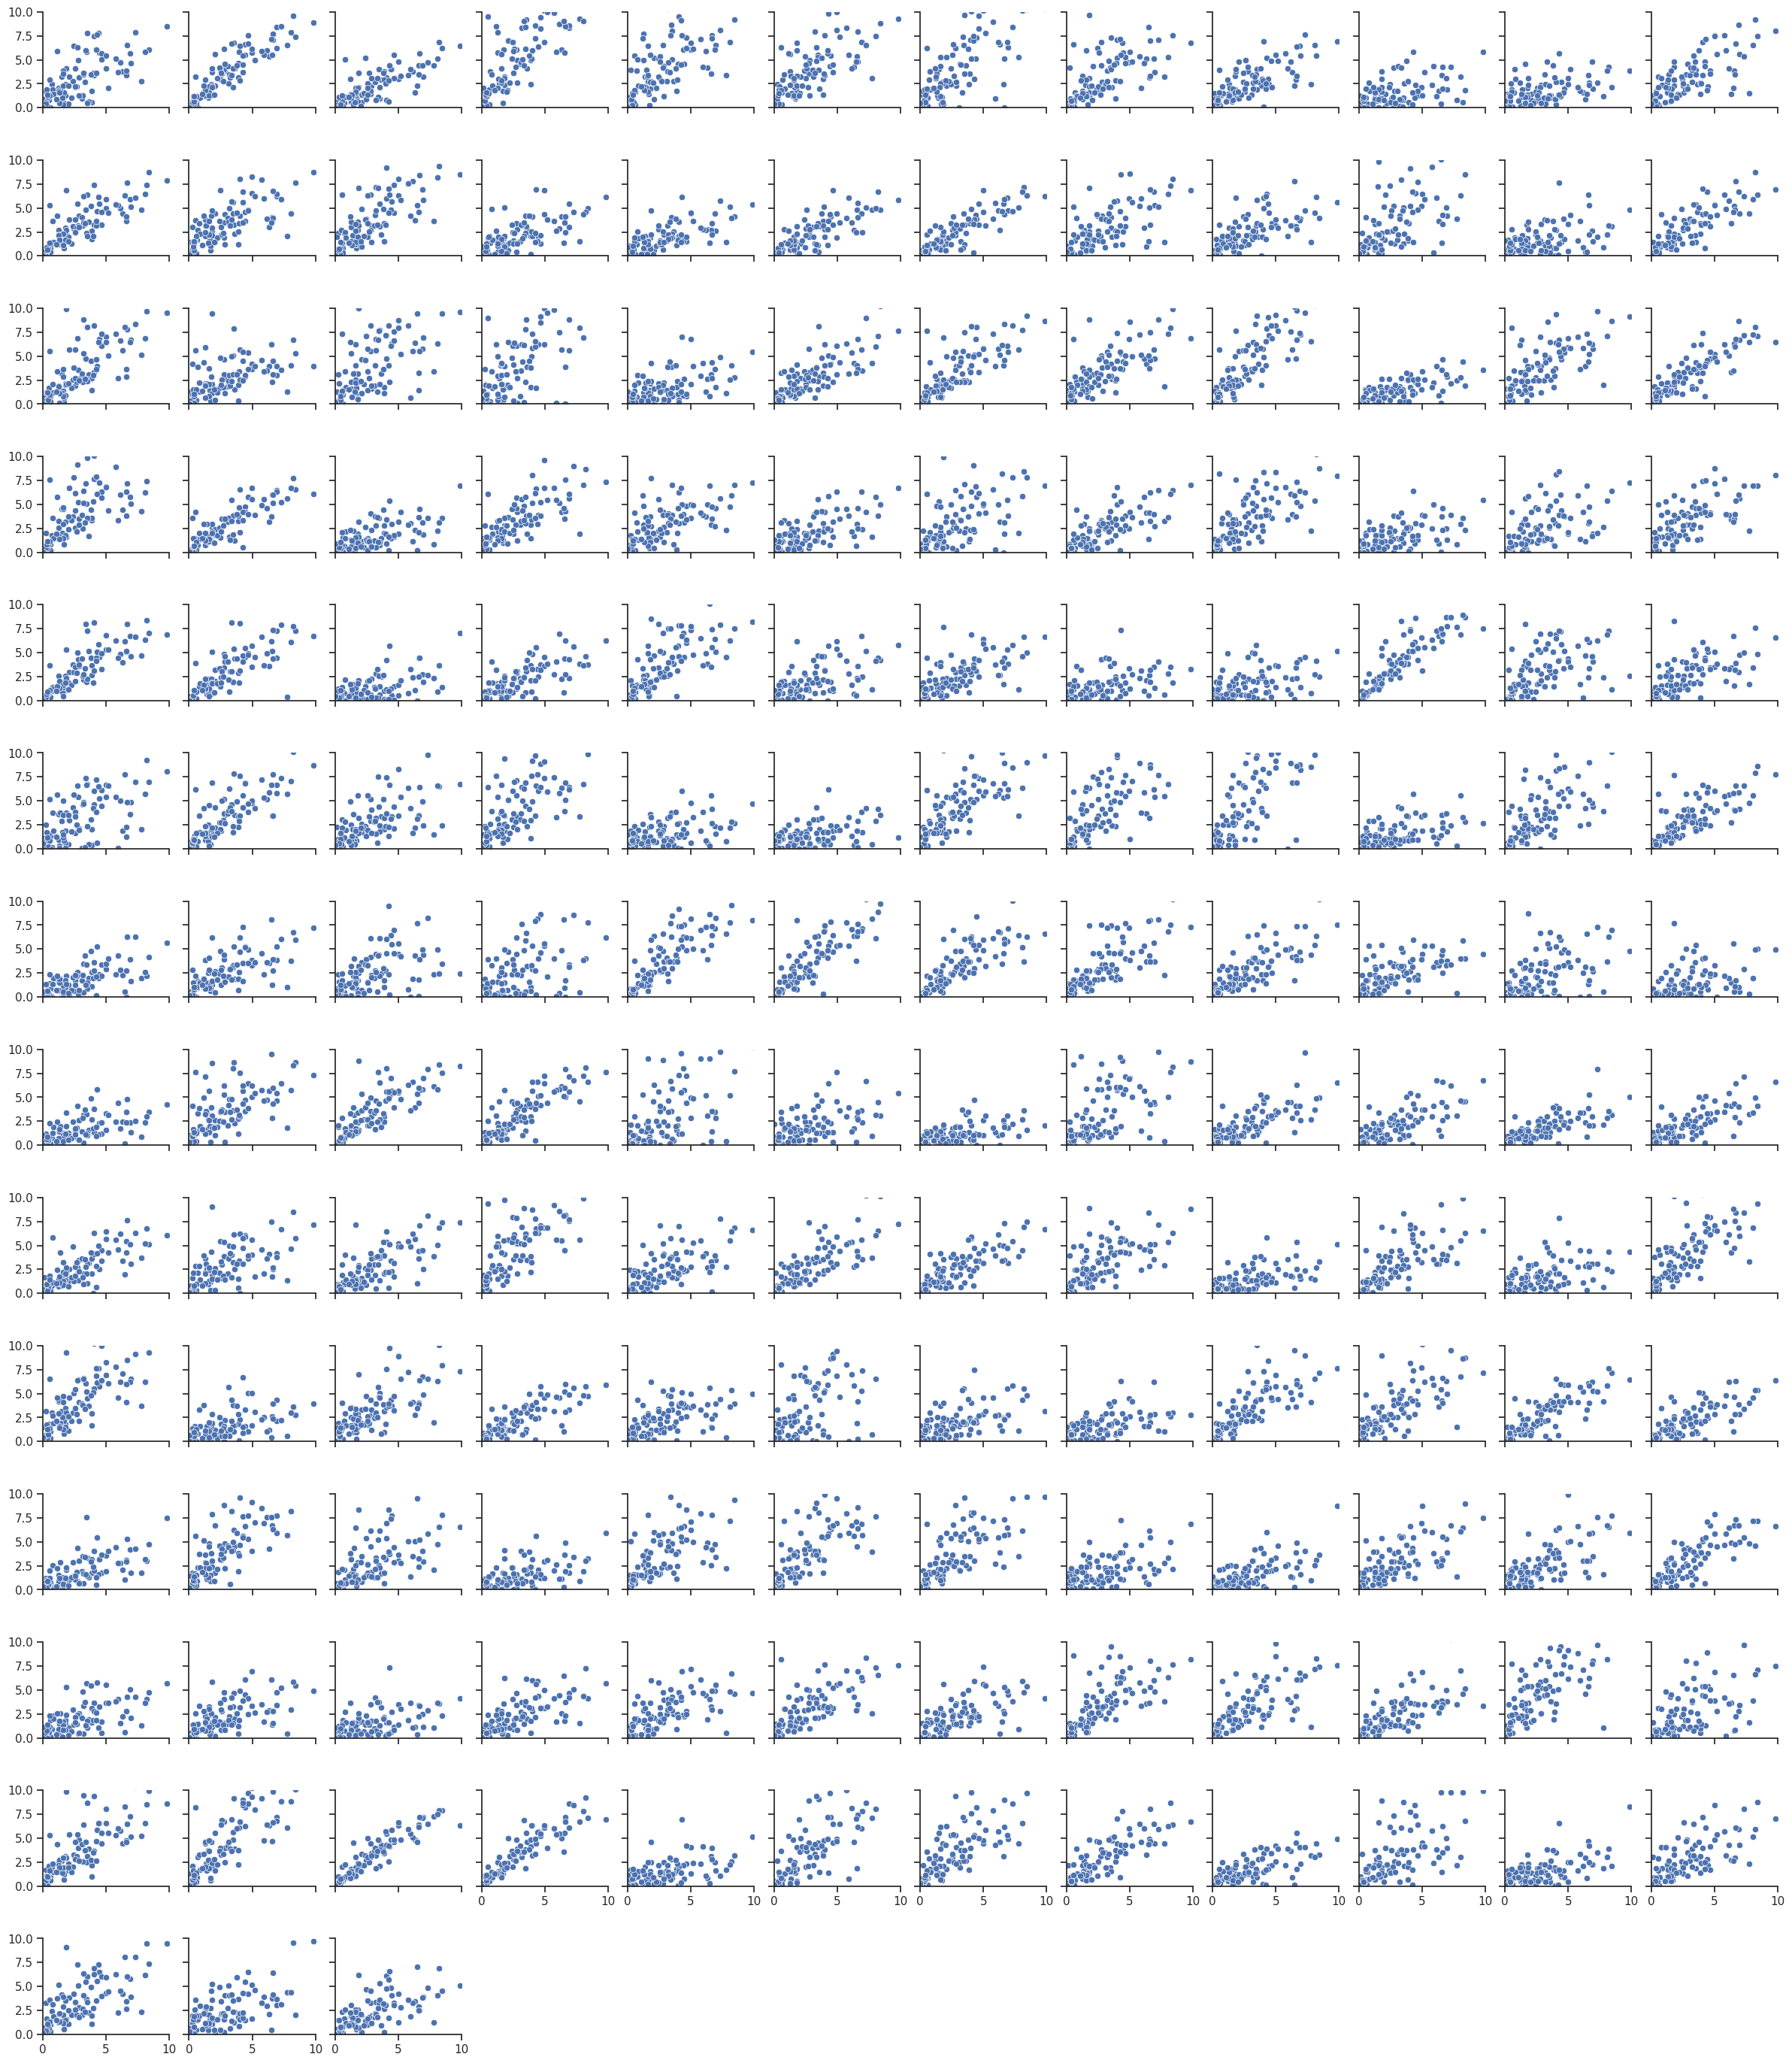

In [ ]:
sns.set(style="ticks")
g = sns.FacetGrid(sel_monthly_df.melt(id_vars=sel_monthly_df.columns[0]), col='variable', col_wrap=12, height=2)
g.map(sns.scatterplot, sel_monthly_df.columns[0], 'value', marker="o")
g.set_titles("")
g.set_axis_labels("", "")

plt.show()
